# Initial demo of model output via Thredds and NLDI
* demo uses siphon to search existing thredds catalog of onhm ouput (note this is still very experimental).  
* seg_outflow is assigned to a variable
* Search NLDI for NHM POI.  POIs provide the cross-walk between the specific model fabric, and the common NHD+ fabric.
* NLDI is searched for all gages and streamsegments upstream of gage 06759500 on the S. Platte River at Fort Morgan.
* Example comparison is given for observed and simulated streamflow 


In [1]:
import py3dep
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import dataretrieval.nwis as nwis
from siphon.catalog import TDSCatalog

In [2]:
# Current test location of NHM ouput
catalog = TDSCatalog("http://gdp-netcdfdev.cr.usgs.gov:8080/thredds/catalog/ONHM_OUTPUT/files/catalog.xml")

In [3]:
info = """
Catalog information
-------------------

Base THREDDS URL: {}
Catalog name: {}
Catalog URL: {}
Metadata: {}
""".format(
    catalog.base_tds_url, catalog.catalog_name, catalog.catalog_url, catalog.metadata
)

print(info)


Catalog information
-------------------

Base THREDDS URL: http://gdp-netcdfdev.cr.usgs.gov:8080
Catalog name: No name found
Catalog URL: http://gdp-netcdfdev.cr.usgs.gov:8080/thredds/catalog/ONHM_OUTPUT/files/catalog.xml
Metadata: {'inherited': True, 'serviceName': 'all'}



In [4]:
for service in catalog.services:
    print(service.name)

all


In [5]:
print("\n".join(catalog.datasets.keys()))

unused_potet.nc
transp_on.nc
tminf.nc
tmaxf.nc
tavgf.nc
swrad.nc
ssres_flow.nc
sroff.nc
soil_to_ssr.nc
soil_to_gw.nc
soil_rechr.nc
soil_moist_tot.nc
soil_moist.nc
snowmelt.nc
snowcov_area.nc
snow_free.nc
snow_evap.nc
slow_stor.nc
slow_flow.nc
seg_width.nc
seg_tave_water.nc
seg_tave_upstream.nc
seg_tave_sroff.nc
seg_tave_lat.nc
seg_tave_gw.nc
seg_tave_air.nc
seg_shade.nc
seg_outflow.nc
recharge.nc
prmx.nc
pref_flow_stor.nc
pref_flow.nc
potet.nc
pkwater_equiv.nc
pk_temp.nc
pk_precip.nc
pk_ice.nc
pk_depth.nc
perv_actet.nc
newsnow.nc
net_snow.nc
net_rain.nc
net_ppt.nc
intcp_on.nc
infil.nc
hru_streamflow_out.nc
hru_sroffp.nc
hru_sroffi.nc
hru_snow.nc
hru_rain.nc
hru_ppt.nc
hru_outflow.nc
hru_lateral_flow.nc
hru_intcpstor.nc
hru_intcpevap.nc
hru_impervstor.nc
hru_impervevap.nc
hru_actet.nc
hortonian_flow.nc
gwres_stor.nc
gwres_in.nc
gwres_flow.nc
freeh2o.nc
dunnian_flow.nc
dprst_vol_open_frac.nc
dprst_vol_open.nc
dprst_stor_hru.nc
dprst_sroff_hru.nc
dprst_seep_hru.nc
dprst_insroff_hru.nc
dpr

In [7]:
dataset = 'seg_outflow.nc'
ds = catalog.datasets[dataset]
print(ds.name, ds.url_path, ds.access_urls, type(ds))

seg_outflow.nc ONHM_OUTPUT/files/seg_outflow.nc {'OPENDAP': 'http://gdp-netcdfdev.cr.usgs.gov:8080/thredds/dodsC/ONHM_OUTPUT/files/seg_outflow.nc', 'UDDC': 'http://gdp-netcdfdev.cr.usgs.gov:8080/thredds/uddc/ONHM_OUTPUT/files/seg_outflow.nc', 'ISO': 'http://gdp-netcdfdev.cr.usgs.gov:8080/thredds/iso/ONHM_OUTPUT/files/seg_outflow.nc', 'NCML': 'http://gdp-netcdfdev.cr.usgs.gov:8080/thredds/ncml/ONHM_OUTPUT/files/seg_outflow.nc', 'NetcdfSubset': 'http://gdp-netcdfdev.cr.usgs.gov:8080/thredds/ncss/ONHM_OUTPUT/files/seg_outflow.nc'} <class 'siphon.catalog.Dataset'>


In [8]:
data = ds.remote_access(service='OPENDAP', use_xarray=True)

In [9]:
data.seg_outflow.attrs

{'long_name': 'Streamflow leaving a segment', 'units': 'cfs'}

# Connect NHM Model ouput on THREDDS with NLDI.
* use GFv11 POI interest, which contains NHD comid for each stream segment.
* GFv11 POIs made available to NLDI through geoconnex

## Use hyriver python tools which have a nice wrapper around NLDI and NWIS
* https://hyriver.readthedocs.io/en/latest/

In [10]:
import hydrodata as hd
from hydrodata import NWIS, plot
from pynhd import NLDI, NHDPlusHR, WaterData

### Search NLDI by navigating above USGS-06759500 gage on S. Platt River above Fort Morgan, CO
* grab all comids and gages on main flowline.  
* Use station comids to filter NHM POIs

In [11]:
gage_id = '06759500'
nldi_flw_main = NLDI().navigate_byid(fsource="nwissite",
                             fid=f"USGS-{gage_id}",
                             navigation="upstreamMain",
                             source="flowlines",
                             distance=50)

nldi_st_all = NLDI().navigate_byid(fsource="nwissite",
                             fid=f"USGS-{gage_id}",
                             navigation="upstreamMain",
                             source="nwissite",
                             distance=50)

nldi_POI_all = NLDI().navigate_byid(fsource="nwissite",
                             fid=f"USGS-{gage_id}",
                             navigation="upstreamMain",
                             source="gfv11_pois",
                             distance=50)

In [12]:
nldi_flw_main.head()

,geometry,nhdplus_comid
0,"LINESTRING (-103.80253 40.26874, -103.80151 40...",3561878
1,"LINESTRING (-103.82914 40.27436, -103.82747 40...",3561874
2,"LINESTRING (-103.83380 40.27505, -103.83288 40...",3561872
3,"LINESTRING (-103.84725 40.28259, -103.84632 40...",3561928
4,"LINESTRING (-103.84846 40.28266, -103.84830 40...",3561850


In [13]:
nldi_st_all.head()

,geometry,source,sourceName,identifier,name,uri,comid,reachcode,measure,navigation
0,POINT (-104.24467 40.30637),nwissite,NWIS Sites,USGS-401823104143900,"SOUTH PLATTE RIVER AT MASTERS, CO",https://waterdata.usgs.gov/monitoring-location...,226643,10190003000027,0E-10,https://labs.waterdata.usgs.gov/api/nldi/linke...
1,POINT (-103.92028 40.32139),nwissite,NWIS Sites,USGS-06758500,"SOUTH PLATTE RIVER NEAR WELDONA, CO",https://waterdata.usgs.gov/monitoring-location...,227923,10190003000022,97.20807,https://labs.waterdata.usgs.gov/api/nldi/linke...
2,POINT (-103.80119 40.26840),nwissite,NWIS Sites,USGS-06759500,"SOUTH PLATTE RIVER AT FORT MORGAN, CO",https://waterdata.usgs.gov/monitoring-location...,3561878,10190012002368,94.85288,https://labs.waterdata.usgs.gov/api/nldi/linke...
3,POINT (-104.24495 40.30581),nwissite,NWIS Sites,USGS-06756995,"SOUTH PLATTE RIVER AT MASTERS, CO.",https://waterdata.usgs.gov/monitoring-location...,226669,10190003001241,97.32596,https://labs.waterdata.usgs.gov/api/nldi/linke...
4,POINT (-104.17912 40.30387),nwissite,NWIS Sites,USGS-06757000,"SOUTH PLATTE RIVER AT SUBLETTE, CO.",https://waterdata.usgs.gov/monitoring-location...,226665,10190003001241,53.22072,https://labs.waterdata.usgs.gov/api/nldi/linke...


In [14]:
nldi_POI_all.head()

,geometry,source,sourceName,identifier,name,uri,comid,reachcode,measure,navigation
0,POINT (-103.90353 40.31102),gfv11_pois,USGS Geospatial Fabric V1.1 Points of Interest,24273,South Platte River,https://geoconnex.us/usgs/gfv11_pois/24273,227923,10190003000022,68.92192,https://labs.waterdata.usgs.gov/api/nldi/linke...
1,POINT (-103.79559 40.26779),gfv11_pois,USGS Geospatial Fabric V1.1 Points of Interest,24735,South Platte River,https://geoconnex.us/usgs/gfv11_pois/24735,3561878,10190012002368,88.41941,https://labs.waterdata.usgs.gov/api/nldi/linke...
2,POINT (-104.07625 40.34529),gfv11_pois,USGS Geospatial Fabric V1.1 Points of Interest,28418,South Platte River,https://geoconnex.us/usgs/gfv11_pois/28418,24847469,10190003002288,0E-10,https://labs.waterdata.usgs.gov/api/nldi/linke...
3,POINT (-103.86086 40.28574),gfv11_pois,USGS Geospatial Fabric V1.1 Points of Interest,24274,South Platte River,https://geoconnex.us/usgs/gfv11_pois/24274,227925,10190003000022,0E-10,https://labs.waterdata.usgs.gov/api/nldi/linke...


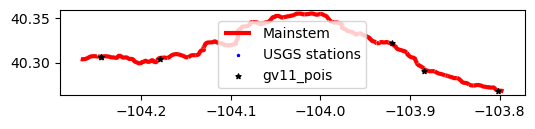

In [15]:
ax = nldi_flw_main.plot(
    lw=3, color="r", zorder=2, label="Mainstem"
)
nldi_st_all.plot(
    ax = ax, label="USGS stations", marker="*", markersize=3, zorder=4, color="b"
)
nldi_st_all.plot(
    ax = ax, label="gv11_pois", marker="*", markersize=14, zorder=5, color="black"
)
ax.legend(loc="best")
ax.set_aspect("equal")
ax.figure.set_dpi(100)

In [16]:
nhm_seg_id = int(nldi_POI_all['identifier'].values[0])


In [17]:
nhm_seg_ouflow = data.isel(nsegment=nhm_seg_id)
nhm_seg_ouflow_cms = nhm_seg_ouflow.seg_outflow * 0.02381

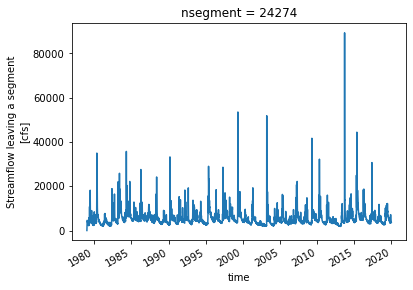

In [18]:
ax = nhm_seg_ouflow.seg_outflow.plot()

### Experiment with a couple packages for retrieving NWIS data.
* hydrodata NWIS package (NWIS)
* dataretreival package (nwis)

In [21]:
from hydrodata import NWIS
site='06758500'
qobs = NWIS().get_streamflow(site, ("1980-01-01", "2007-12-31"))

In [22]:
type(qobs['USGS-06758500'])

pandas.core.series.Series

# Comparison of observed vs simulated

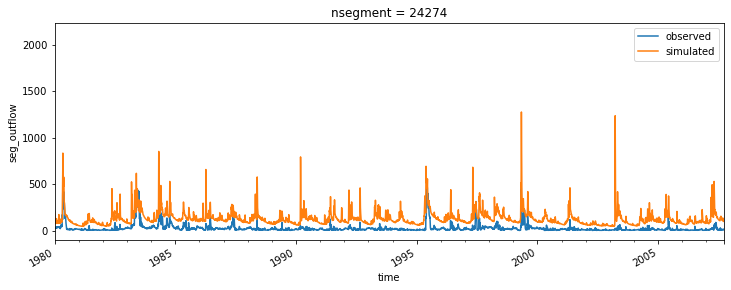

In [23]:
fig, axs = plt.subplots(figsize=(12, 4))
qobs['USGS-06758500'].plot(ax=axs, label="observed")
nhm_seg_ouflow_cms.plot(ax=axs, label="simulated")
axs.legend()